## Question 5 - Do more experienced players keep their queens on the board for longer?

Queens are the most flexible pieces on the board, so keeping them on the board allows for positions to be more complex. If players want to simplify positions, one strategy is to trade down pieces to maintain material equality, while making it easier to analyze lines while thinking. Thus, we are interested in if the elo of the players playing is correlated with how long the queens stay on the board, and if they are correlated, in which direction.

Due to pawn promotions, I have decided to track how long the queens last on the board by finding the first ply for which the board FEN data does not contain the queen. The white queen is denoted by Q and the black queen is denoted by q, so for each game, I find the first row that does not have these characters.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import linregress

### Data Preprocessing and Loading

We use the 10+0 games again. The variables we want are
- board, to see if the Queens are there or not,
- game id,
- player elo,
- move number,
- number of moves (in the cases where the queens survive until the end of the game).

In [2]:
url = "https://csslab.cs.toronto.edu/data/chess/monthly/lichess_db_standard_rated_2019-01.csv.bz2"

# these variables we can change
max_chunks = 30
chunksize = 1e6
columns_to_load = ['game_id', 'white_elo', 'black_elo', 'num_ply', 'move_ply', 'board', 'time_control']
dtype = {'game_id':str, 'white_elo':int, 'black_elo':int, 'num_ply':int, 'move_ply':int, 'board':str, 'time_control':str}

# these variables we cannot
# define the conditions to filter the rows
condition = lambda df: df['time_control'] == '600+0'
chunk_counter = 0
filtered_chunks = []

start_time = time.time()
for chunk in pd.read_csv(url, compression='bz2', usecols = columns_to_load, chunksize=chunksize, dtype=dtype):
    filtered_chunk = chunk[condition(chunk)]
    filtered_chunks.append(filtered_chunk)
    chunk_counter += 1

    if chunk_counter >= max_chunks:
        break

raw = pd.concat(filtered_chunks, ignore_index=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to read the first {chunk_counter} chunks of size {chunksize:.2e}: {elapsed_time:.2f} seconds")

print(raw.shape)
raw.head()

Time taken to read the first 30 chunks of size 1.00e+06: 623.33 seconds
(5524226, 7)


,game_id,white_elo,black_elo,time_control,num_ply,move_ply,board
0,mAEz2AcC,1702,1628,600+0,36,0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...
1,mAEz2AcC,1702,1628,600+0,36,1,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...
2,mAEz2AcC,1702,1628,600+0,36,2,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...
3,mAEz2AcC,1702,1628,600+0,36,3,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...
4,mAEz2AcC,1702,1628,600+0,36,4,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...


For each game, we want to find and store the value of the first row's ply number that does not have each queen in the board string. The board is stored using FEN (Forsyth-Edwards Notation). Under this method, white queens are represented by the character Q and black queens are represented by the character q. For each of these characters, we find the first row for which these characters do not exist, and store the value. If the queen(s) last until the end of the game, we store NA instead.

In [11]:
raw.drop(columns=['time_control'], inplace=True)

In [17]:
def find_no_q_move(group):
    for index, row in group.iterrows():
        if 'q' not in row['board']:
            return row['move_ply']
    return np.nan

def find_no_Q_move(group):
    for index, row in group.iterrows():
        if 'Q' not in row['board']:
            return row['move_ply']
    return np.nan

df_q = raw.groupby('game_id').apply(find_no_q_move).reset_index(name='no_q')
df_Q = raw.groupby('game_id').apply(find_no_Q_move).reset_index(name='no_Q')
df = pd.merge(df_q, df_Q, on='game_id')

df = pd.merge(df, raw.drop(columns=['move_ply', 'board']).drop_duplicates(subset='game_id'), on='game_id')
df.head()

<ipython-input-17-978bd6ace794>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_q = raw.groupby('game_id').apply(find_no_q_move).reset_index(name='no_q')
<ipython-input-17-978bd6ace794>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_Q = raw.groupby('game_id').apply(find_no_Q_move).reset_index(name='no_Q')


,game_id,no_q,no_Q,white_elo,black_elo,num_ply
0,0059ikZy,NaN,NaN,906,890,67
1,005ZOW5z,NaN,NaN,1429,1434,50
2,005uCwGv,NaN,NaN,1890,1852,33
3,007kYqPc,NaN,NaN,1053,1103,47
4,00ATYBh2,NaN,48.0,1430,1468,50


Now, for each game, we also want to find the average elo of the players, and the average of the moves that the two queens got removed. For now, consider only games where the two queens did get captured.

In [19]:
df['no_Q'].isna().sum()

46111

In [20]:
df.shape

(86477, 6)

In [22]:
df['elo'] = df[['white_elo', 'black_elo']].mean(axis=1)

df['avg_no_queen'] = df.apply(lambda row: np.nan if pd.isna(row['no_q']) or pd.isna(row['no_Q'])
                              else (row['no_q'] + row['no_Q']) / 2, axis=1)

df.head(10)

,game_id,no_q,no_Q,white_elo,black_elo,num_ply,elo,avg_no_queen
0,0059ikZy,NaN,NaN,906,890,67,898.0,NaN
1,005ZOW5z,NaN,NaN,1429,1434,50,1431.5,NaN
2,005uCwGv,NaN,NaN,1890,1852,33,1871.0,NaN
3,007kYqPc,NaN,NaN,1053,1103,47,1078.0,NaN
4,00ATYBh2,NaN,48.0,1430,1468,50,1449.0,NaN
5,00DZWd7H,NaN,NaN,1446,1409,47,1427.5,NaN
6,00E9w018,NaN,36.0,1351,1387,38,1369.0,NaN
7,00Emm8WQ,47.0,44.0,1833,1858,61,1845.5,45.5
8,00GjNmU3,37.0,38.0,1580,1595,85,1587.5,37.5
9,00HOIEiW,89.0,88.0,1281,1423,92,1352.0,88.5


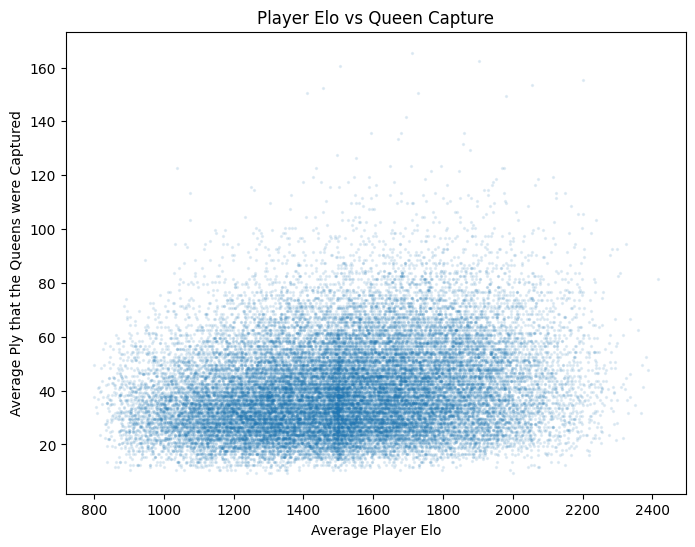

In [24]:
df_filtered = df.dropna(subset=['avg_no_queen'])

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['elo'], df_filtered['avg_no_queen'], s=2, alpha=0.1)
plt.title('Player Elo vs Queen Capture')
plt.xlabel('Average Player Elo')
plt.ylabel('Average Ply that the Queens were Captured')
plt.show()

In [27]:
slope, intercept, r_value, p_value, std_err = linregress(df_filtered['elo'], df_filtered['avg_no_queen'])
print(f"Number of Games: {df_filtered.shape[0]}")
print(f"Slope of the line of best fit: {slope:.3f}")
print(f"Correlation Coefficient: {r_value:.3f}")
print(f"p-value of a slope of 0: {p_value:.3e}")

Number of Games: 33053
Slope of the line of best fit: 0.012
Correlation Coefficient: 0.205
p-value of a slope of 0: 0.000e+00


It seems like there is a lot of games at the 1500 elo mark. This makes sense because when a player first makes an account, they start with 1500 elo. We might be concerned that this makes up a large portion of the data. If it is, we might want to remove the games where a player was brand new.

Under the assumption that the new players are representative of the total population of players, this actually is not going to warp our results. This is because we will still observe the queens being captured at the same ply numbers, if any, if the players were instead assigned their elo based on their actual skill.

In [28]:
count_1500_white = (df['white_elo'] == 1500).sum()
count_1500_black = (df['black_elo'] == 1500).sum()

# Total count of 1500 in both columns
total_count_1500 = count_1500_white + count_1500_black

# Print the results
print("1500 appears", count_1500_white, "times in the 'white_elo' column.")
print("1500 appears", count_1500_black, "times in the 'black_elo' column.")
print("Total count of 1500 in both columns:", total_count_1500)

1500 appears 1902 times in the 'white_elo' column.
1500 appears 1268 times in the 'black_elo' column.
Total count of 1500 in both columns: 3170


### Question 5.1.1 - Are players who kept their Queen more likely to have a higher elo?

Now, let's visualize the distribution of the elos of the players who kept their queens until the end of the game. We also want to note the distribution of the elo for all games to see if they differ, and if so, how significantly. However, to address the potential issue where the NAs make up a very small or very large portion of the dataset, we instead keep track of the complement, ie the elos of players that did not keep their queens.

The current maximum and minimum possible elo one can have on Lichess are 400 and 2800, respectively. At the time of the data, this minimum is likely to be 800, so we instead set this as the minimum.

In [46]:
bin_edges = np.arange(800, 2801, 20)

# get one series of all the elos of players who kept or lost their queens
kept_queens = pd.concat([df[df['no_Q'].isna()]['white_elo'], df[df['no_Q'].isna()]['black_elo']], ignore_index=True)
lost_queens = pd.concat([df[df['no_Q'].notna()]['white_elo'], df[df['no_Q'].notna()]['black_elo']], ignore_index=True)

all_elo = pd.concat([df['white_elo'], df['black_elo']])

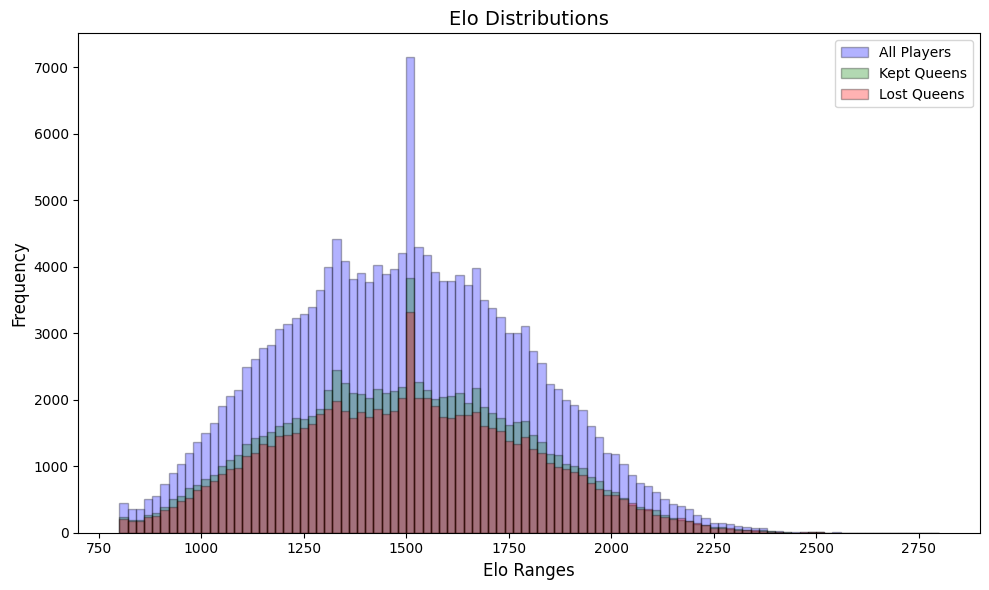

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(all_elo, bins=bin_edges, alpha=0.3, label='All Players', color='blue', edgecolor='black')
plt.hist(kept_queens, bins=bin_edges, alpha=0.3, label='Kept Queens', color='green', edgecolor='black')
plt.hist(lost_queens, bins=bin_edges, alpha=0.3, label='Lost Queens', color='red', edgecolor='black')

plt.title('Elo Distributions', fontsize=14)
plt.xlabel('Elo Ranges', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()

The densities might be more useful...

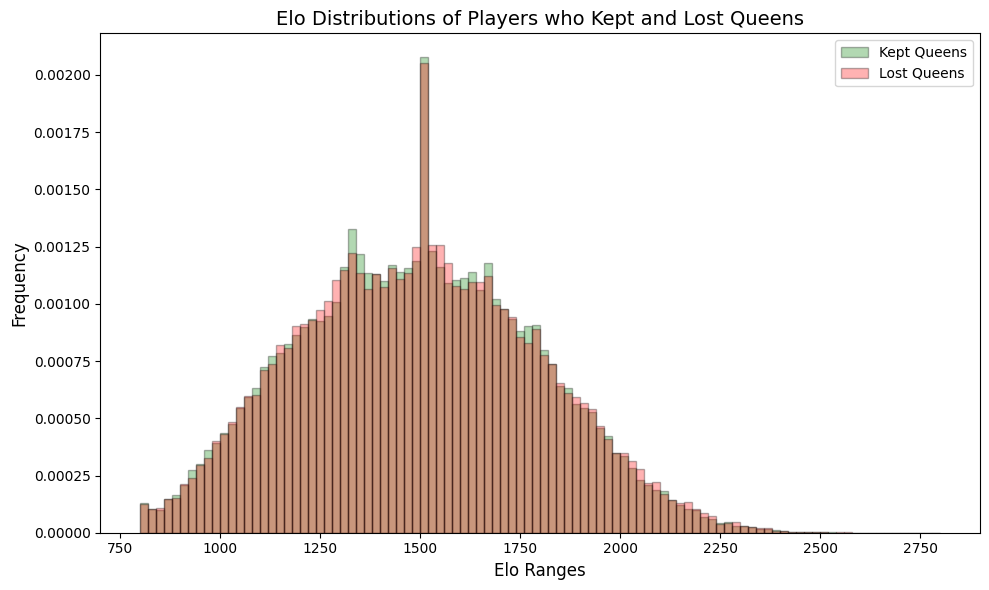

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(kept_queens, bins=bin_edges, alpha=0.3, label='Kept Queens', color='green', edgecolor='black', density=True)
plt.hist(lost_queens, bins=bin_edges, alpha=0.3, label='Lost Queens', color='red', edgecolor='black', density=True)

plt.title('Elo Distributions of Players who Kept and Lost Queens', fontsize=14)
plt.xlabel('Elo Ranges', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()

These look matching to me!

### Question 5.1.2 - Are more experienced players more likely to keep their Queens until the end of the game?

Now let's find the (arguably more interesting) converse question. To answer this question, we bin the players' elos and then find the percentage of the players in each bin that managed to keep their queens until the end of the game.

In [80]:
bin_edges = np.arange(800, 2801, 100) # wider bins

all_freq = pd.cut(all_elo, bins=bin_edges, right=False).value_counts().sort_index().reset_index()
kept_freq = pd.cut(kept_queens, bins=bin_edges, right=False).value_counts().sort_index().reset_index()
all_freq.columns = ['Elo Range', 'All']
kept_freq.columns = ['Elo Range', 'Kept']

kept_percentage = pd.merge(all_freq, kept_freq, on='Elo Range')
kept_percentage['Percentage'] = 100.0 * kept_percentage['Kept'] / kept_percentage['All']

kept_percentage.dropna(subset=['Percentage'], inplace=True)
kept_percentage.head()

,Elo Range,All,Kept,Percentage
0,"[800, 900)",2218,1183,53.336339
1,"[900, 1000)",5219,2834,54.301590
2,"[1000, 1100)",9243,4944,53.489127
3,"[1100, 1200)",13755,7327,53.267903
4,"[1200, 1300)",16671,8698,52.174435


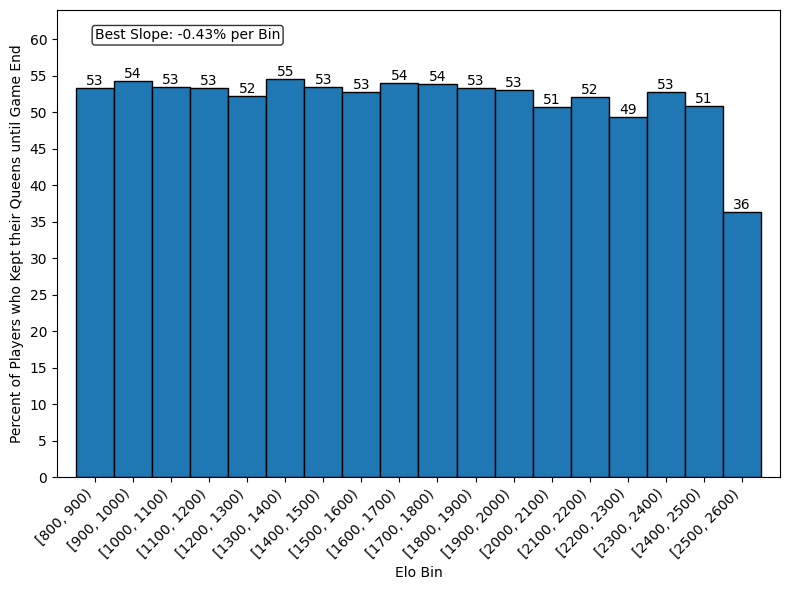

In [97]:
plt.figure(figsize=(8,6))

# code mostly modified from Question 3 notebook
bars = plt.bar(kept_percentage['Elo Range'].astype(str), kept_percentage['Percentage'], width=1, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height)}',
                ha='center', va='bottom', fontsize=10)

buffer = 5
y_max = (int) (kept_percentage['Percentage'].max())
plt.ylim(0, y_max + 2*buffer)
y_ticks = np.arange(0, y_max + 2*buffer, 5)
plt.yticks(y_ticks, y_ticks)

plt.xlim(-1, len(kept_percentage['Elo Range']))
tick_positions = range(len(kept_percentage['Elo Range']))
plt.xticks(tick_positions, kept_percentage['Elo Range'].astype(str), rotation=45, ha='right')

plt.xlabel("Elo Bin")
plt.ylabel("Percent of Players who Kept their Queens until Game End")

slope, intercept, r_value, p_value, std_err = linregress(kept_percentage.index, kept_percentage['Percentage'])
plt.text(0, y_max+1.5*buffer, f'Best Slope: {slope:.2f}% per Bin', fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.2'))

plt.tight_layout()
plt.show()

By binning the players, we help reduce the effect of placing too much importance on more populated bins, which helps make sure the extremes are also weighted equally. As the chart shows, there is a slight decrease as the elo increases. This trend is noticeable too even if we exclude the final bar of 36.